In [132]:
import pygame
import numpy as np
import gym
import time
import matplotlib.pyplot as plt

# Reinforcement learning in Cart Pole enviorment
[Gym Documentation](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.
#### States
1. The cart position x (-4.8, 4.8)
2. The cart velocity x_dot (-inf, inf)
3. The cart angle theta (-24, 24)° -> (-0.418, 0.418)rad
4. The cart velocity theta_dot (-inf, inf)
#### Actions
1 - push cart to the right
0 - push cart to the left
#### Rewards
Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted.
#### Termination criteria
- Pole Angle is greater than ±12°
- Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- Episode length is greater than 500.

#### Q-Learning
`Q(s, a) = Q(s, a) + alpha * (nagrada + gama * max(Q(s', a')) - Q(s, a))`

In [133]:
class Q_Learning:
     
    def __init__(self, env, alpha, gamma, epsilon, numberEpisodes, k, lowerBounds, upperBounds):
        '''
        INPUTS: 
        env - Cart Pole environment
        alpha - step size 
        gamma - discount rate
        epsilon - for epsilon-greedy
        numberEpisodes - total number of simulation episodes
        
        k - this is a 4 dimensional list that defines the number of grid points 
        for state discretization
        that is, this list contains number of bins for every state entry, 
        we have 4 entries, that is,
        discretization for [x, x_dot, theta, theta_dot] 
        
        lowerBounds, upperBounds - bounds (limits) for discretization, list with 4 entries:
        lower bounds on [x, x_dot, theta, theta_dot] 
        '''
        self.env = env
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.actionNumber = env.action_space.n 
        self.numberEpisodes = numberEpisodes
        self.k = k
        self.lowerBounds = lowerBounds
        self.upperBounds = upperBounds
        self.min_alpha = 0.01
        self.initial_alpha = alpha
         
        self.sumRewardsEpisode = []
         
        self.Qmatrix = np.random.uniform(low=0, high=1, size=(k[0],k[1],k[2],k[3],self.actionNumber))
         
     
    def returnIndexState(self,state):
        '''
        Based on state vector, this function returns cell value for states in Q matrix,
        using discretization.

        INPUTS:
        state - state list/array, [x, x_dot, theta, theta_dot] 
    
        OUTPUT: 4-dimensional tuple defining the cell value for states in Q matrix 
        that correspond to "state" input
        '''
        x = state[0]
        x_dot = state[1]
        theta = state[2]
        theta_dot = state[3]
        
        # linspace function creates evenly spaced values between specified lower and upper bounds
        cartPositionBin = np.linspace(self.lowerBounds[0],self.upperBounds[0],self.k[0])
        cartVelocityBin = np.linspace(self.lowerBounds[1],self.upperBounds[1],self.k[1])
        poleAngleBin = np.linspace(self.lowerBounds[2],self.upperBounds[2],self.k[2])
        poleAngleVelocityBin = np.linspace(self.lowerBounds[3],self.upperBounds[3],self.k[3])
        
        # digitize function is used to find the index of the bin into which each continuous state variable falls
        indexPosition = np.maximum(np.digitize(x, cartPositionBin)-1,0)
        indexVelocity = np.maximum(np.digitize(x_dot, cartVelocityBin)-1,0)
        indexAngle = np.maximum(np.digitize(theta, poleAngleBin)-1,0)
        indexAngularVelocity = np.maximum(np.digitize(theta_dot, poleAngleVelocityBin)-1,0)
        
        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])   
   

    def selectAction(self,state,index):
        '''
        Selects an action on the basis of the current state

        INPUTS: 
        state - state for which to compute the action
        index - index of the current episode
        
        Epsilon greedy
        
        if p<epsilon: we are exploring (selecting random actions)
        else: exploatation (choosing the best action)

        At the 3/4 point of the assigned episodes, epsilon starts to decrease.
        This means that we choose exploatation instead of exploration.
        '''

        # # first 500 episodes we select completely random actions to have enough exploration
        # if index<500:
        #     return np.random.choice(self.actionNumber)   

        p = np.random.random()
        
        if index > (3*self.numberEpisodes/4):
            self.epsilon = 0.999*self.epsilon
         
        if p < self.epsilon:
            return np.random.choice(self.actionNumber)            
         
        else:
            return np.random.choice(np.where(self.Qmatrix[self.returnIndexState(state)] == np.max(self.Qmatrix[self.returnIndexState(state)]))[0])
            # if theres more max values, we choose first action, np.random.choice(np.where(a==np.max(a))[0])
 
      
    def simulateEpisodes(self):
        '''
        Simulates learning episodes over the entire duration set by `numberEpisodes`.

        It selects actions based on the current state, updates the Q-matrix based on the 
        rewards received, maximizing the sum of rewards.

        Q-Learning algorithm

        During each episode:
        - The environment is reset to a starting state.
        - Actions are chosen and performed until a terminal state is reached.
        - Action selection based on the current state is done using an epsilon-greedy strategy.
        - The Q-matrix is updated based on the action outcomes and received rewards.

        Rewards are accumulated throughout the episode and printed at the end, along with
        the cumulative reward for the entire episode.
        '''
        
        for indexEpisode in range(self.numberEpisodes):
             
            # self.alpha = max(self.initial_alpha * (0.995 ** indexEpisode), self.min_alpha)
            rewardsEpisode=[]
             
            (stateS,_) = self.env.reset()
            stateS = list(stateS)
           
            print("Simulating episode {}".format(indexEpisode))
             
             
            terminalState = False
            while not terminalState:
                 
                stateSIndex = self.returnIndexState(stateS)
                 
                actionA = self.selectAction(stateS,indexEpisode)
                 
                (stateSprime, reward, terminalState,_,_) = self.env.step(actionA)          
                 
                rewardsEpisode.append(reward)
                 
                stateSprime = list(stateSprime)
                 
                stateSprimeIndex = self.returnIndexState(stateSprime)
                 
                QmaxPrime = np.max(self.Qmatrix[stateSprimeIndex])                                               
                                              
                if not terminalState:
                    error = reward+self.gamma*QmaxPrime-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)] = self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                else:
                    error = reward-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)] = self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                                   
                stateS = stateSprime
         
            print("Sum of rewards {}".format(np.sum(rewardsEpisode)))        
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))
       

    def simulateLearnedStrategy(self):
        '''
        Simulates the execution of the final learned optimal policy using a CartPole-v1 enviorment. 
        Tests the performance of the learned policy by selecting the best actions (greedy strategy) based on the Q-matrix.
        
        Steps:
        - Initializing the Cart Pole environment with a visualization mode to watch the policy in action.
        - Resetting the environment to begin at an initial state.
        - Iteratively selecting actions according to the highest values in the Q-matrix for up to 1000 time steps or until termination.
        - Recording the rewards obtained at each time step to evaluate the effectiveness of the learned policy.

        The process halts when the agent reaches a terminal state.

        OUTPUT: 
        env1 - Cart Pole environment
        obtainedRewards - a list of obtained rewards during time steps of a single episode
        '''
        env1 = gym.make('CartPole-v1',render_mode='human')
        (currentState,_) = env1.reset()
        env1.render()
        timeSteps = 1000
        obtainedRewards = []
         
        for timeIndex in range(timeSteps):
            print(timeIndex)
            # select greedy actions
            actionInStateS = np.random.choice(np.where(self.Qmatrix[self.returnIndexState(currentState)] == np.max(self.Qmatrix[self.returnIndexState(currentState)]))[0])
            currentState, reward, terminated, truncated, info  = env1.step(actionInStateS)
            obtainedRewards.append(reward)
            time.sleep(0.05)
            if (terminated):
                time.sleep(1)
                break
        return obtainedRewards,env1   
       

    def simulateRandomStrategy(self):
        '''
        Simulates a series of episodes using random actions within the Cart Pole environment
        to evaluate and compare the performance of a random policy against the optimal policy.

        Key operations include:
        - Creating and initializing a new Cart Pole environment.
        - Setting a fixed number of episodes and time steps for each simulation.
        - For each episode, actions are chosen randomly from the available action space.
        - Rewards for each action are recorded and accumulated until the episode terminates or reaches the time limit.

        OUTPUT:
        - sumRewardsEpisodes: A list containing the sum of rewards for each episode
        - env2: Cart Pole environment 
        '''
        env2 = gym.make('CartPole-v1')
        (currentState,_) = env2.reset()
        env2.render()
        episodeNumber = 100
        timeSteps = 1000
        sumRewardsEpisodes = []
         
         
        for episodeIndex in range(episodeNumber):
            rewardsSingleEpisode = []
            initial_state = env2.reset()
            print(episodeIndex)
            for timeIndex in range(timeSteps):
                random_action = env2.action_space.sample()
                observation, reward, terminated, truncated, info = env2.step(random_action)
                rewardsSingleEpisode.append(reward)
                if (terminated):
                    break
            sumRewardsEpisodes.append(np.sum(rewardsSingleEpisode))
        return sumRewardsEpisodes,env2 

In [134]:
env=gym.make('CartPole-v1')
(state,_) = env.reset()

# Discretization 
# for x and theta, set the limits to the ones defined by gym
# since x_dot and theta_dot have limits (-inf, inf) some other values are provided
upperBounds = env.observation_space.high
lowerBounds = env.observation_space.low
env.render()
env.close()
# x_dot
upperBounds[1] = 3
lowerBounds[1] = -3
# theta_dot
upperBounds[3] = 13
lowerBounds[3] = -13

# k- rezolucija
k_x = 25
k_x_dot = 25
k_theta = 25
k_theta_dot = 25
k = [k_x, k_x_dot, k_theta, k_theta_dot]
 
# define the parameters
alpha = 0.25
gamma = 0.9
epsilon = 0.2
numberEpisodes = 12000

Q1 = Q_Learning(env,alpha,gamma,epsilon,numberEpisodes,k,lowerBounds,upperBounds)
Q1.simulateEpisodes()

Simulating episode 0
Sum of rewards 30.0
Simulating episode 1
Sum of rewards 105.0
Simulating episode 2
Sum of rewards 16.0
Simulating episode 3
Sum of rewards 29.0
Simulating episode 4
Sum of rewards 31.0
Simulating episode 5
Sum of rewards 22.0
Simulating episode 6
Sum of rewards 19.0
Simulating episode 7
Sum of rewards 16.0
Simulating episode 8
Sum of rewards 12.0
Simulating episode 9
Sum of rewards 16.0
Simulating episode 10
Sum of rewards 40.0
Simulating episode 11
Sum of rewards 11.0
Simulating episode 12
Sum of rewards 31.0
Simulating episode 13
Sum of rewards 14.0
Simulating episode 14
Sum of rewards 41.0
Simulating episode 15
Sum of rewards 17.0
Simulating episode 16
Sum of rewards 31.0
Simulating episode 17
Sum of rewards 19.0
Simulating episode 18
Sum of rewards 12.0
Simulating episode 19
Sum of rewards 26.0
Simulating episode 20
Sum of rewards 10.0
Simulating episode 21
Sum of rewards 23.0
Simulating episode 22
Sum of rewards 26.0
Simulating episode 23
Sum of rewards 27.0
S

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(Q1.sumRewardsEpisode,linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [150]:
(obtainedRewardsOptimal,env1)=Q1.simulateLearnedStrategy()

env1.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


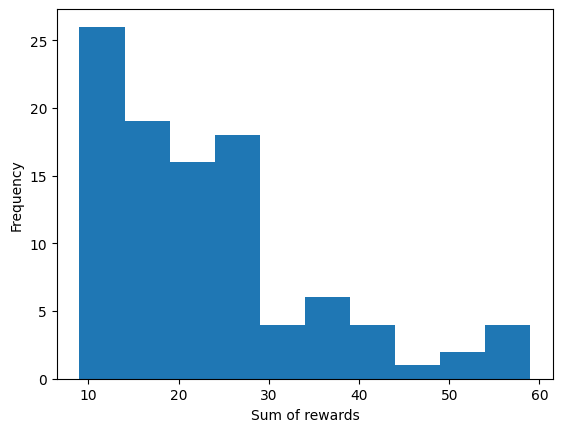

In [155]:
# now simulate a random strategy
(obtainedRewardsRandom,env2) = Q1.simulateRandomStrategy()
plt.hist(obtainedRewardsRandom)
plt.xlabel('Sum of rewards')
plt.ylabel('Frequency')
plt.show()